# Controller vs Controller Comparison

This notebook compares NR/NR Enhanced control against NMPC control across different trajectories.

**Structure:**
- Separate sections for Simulation and Hardware
- Top row: NR or NR Enhanced trajectories
- Bottom row: NMPC trajectories
- Matched trajectories for easy comparison
- Automatic 2D plane detection per trajectory

**Trajectories:**
- Horizontal Circle (Circle A)
- Vertical Circle (Circle B)
- Horizontal Lemniscate (Lemniscate A)
- Vertical Short Lemniscate (Lemniscate B)
- Vertical Tall Lemniscate (Lemniscate C)
- Regular Helix (Helix A)
- Yawing Helix (Helix B)
- Yawing Horizontal Circle (Circle C)

## 1. Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Force reload utilities module to get latest changes
import importlib
import sys
if 'utilities' in sys.modules:
    importlib.reload(sys.modules['utilities'])

# Import utilities
from utilities import (
    load_all_csvs,
    extract_metadata_from_data,
    detect_trajectory_plane,
    plot_trajectory_2d,
    calculate_position_rmse,
    align_reference_to_actual,
    is_pyjoules_file,
    PLATFORM_NAMES,
    CONTROLLER_NAMES,
    TRAJECTORY_NAMES
)

# Use default matplotlib style (white background)
plt.style.use('default')

# Font and figure settings
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'EB Garamond', 'EB Garamond 12', 'Liberation Sans', 'Arial']

## 2. Configuration

**Choose which NR controller to compare against NMPC:**
- `'NR Standard'` (controller enum 0)
- `'NR Enhanced'` (controller enum 1)

In [2]:
# ===== CONFIGURATION =====
NR_CONTROLLER_CHOICE = 'NR Enhanced'  # <-- Change to 'NR Standard' or 'NR Enhanced'

# Plot styling
subfigure_title_fontsize = 14
tick_size = 10
show_gridlines = False  # <-- Set to False to remove gridlines

# Trajectory trimming (in seconds)
start_trim_seconds = 5.0  # <-- Cut off first X seconds of trajectory
end_trim_seconds = 0.0    # <-- Cut off last Y seconds of trajectory

# Reference alignment
lookahead_time = 1.2  # <-- Lookahead time in seconds for reference alignment

# Reference plotting
plot_one_cycle_ref = True  # <-- Only plot one cycle of reference trajectory
cycle_detection_threshold = 0.1  # <-- Distance threshold (meters) for cycle detection
# =========================

# Path to log files directory
logs_path = "log_files/"

# Output directory for figures
output_path = "output/"
os.makedirs(output_path, exist_ok=True)

print(f"Configuration:")
print(f"  NR Controller: {NR_CONTROLLER_CHOICE}")
print(f"  Comparing against: MPC")
print(f"  Log files: {logs_path}")
print(f"  Output: {output_path}")
print(f"  Gridlines: {'On' if show_gridlines else 'Off'}")
print(f"  Trajectory trimming: Start={start_trim_seconds}s, End={end_trim_seconds}s")
print(f"  Lookahead time: {lookahead_time}s")
print(f"  Plot one cycle ref: {plot_one_cycle_ref}")

Configuration:
  NR Controller: NR Enhanced
  Comparing against: MPC
  Log files: log_files/
  Output: output/
  Gridlines: Off
  Trajectory trimming: Start=5.0s, End=0.0s
  Lookahead time: 1.2s
  Plot one cycle ref: True


## 3. Load and Organize Data

In [3]:
# Load all CSV files (excluding pyJoules_files subdirectory)
data_dict = load_all_csvs(logs_path, exclude_dirs=['pyJoules_files'])

print(f"Loaded {len(data_dict)} CSV files")

# Organize data by platform, pyjoules status, controller, and trajectory
organized_data = {
    'Simulation PyJoules': {
        NR_CONTROLLER_CHOICE: {},
        'MPC': {}
    },
    'Simulation Non-PyJoules': {
        NR_CONTROLLER_CHOICE: {},
        'MPC': {}
    },
    'Hardware PyJoules': {
        NR_CONTROLLER_CHOICE: {},
        'MPC': {}
    },
    'Hardware Non-PyJoules': {
        NR_CONTROLLER_CHOICE: {},
        'MPC': {}
    }
}

# Process each file and organize by platform/pyjoules/controller/trajectory
for filename, df in data_dict.items():
    # Pass filename to extract_metadata_from_data for controller parsing
    metadata = extract_metadata_from_data(df, filename=filename)
    
    platform = metadata['platform']
    controller = metadata['controller']
    trajectory = metadata['trajectory']
    
    # Determine pyjoules status
    is_pyj = is_pyjoules_file(filename)
    
    # Construct the key for organized_data
    if platform == 'Simulation':
        platform_key = 'Simulation PyJoules' if is_pyj else 'Simulation Non-PyJoules'
    elif platform == 'Hardware':
        platform_key = 'Hardware PyJoules' if is_pyj else 'Hardware Non-PyJoules'
    else:
        continue  # Skip unknown platforms
    
    # Skip if controller not recognized
    if controller not in organized_data[platform_key]:
        continue
    
    # Store the dataframe
    organized_data[platform_key][controller][trajectory] = {
        'df': df,
        'filename': filename,
        'metadata': metadata
    }

# Print summary
print("\nData Organization:")
print("=" * 60)
for platform_key in ['Simulation PyJoules', 'Simulation Non-PyJoules', 
                     'Hardware PyJoules', 'Hardware Non-PyJoules']:
    print(f"\n{platform_key}:")
    for controller in [NR_CONTROLLER_CHOICE, 'MPC']:
        n_traj = len(organized_data[platform_key][controller])
        print(f"  {controller}: {n_traj} trajectories")
        if n_traj > 0:
            for traj_name in organized_data[platform_key][controller].keys():
                print(f"    - {traj_name}")

Loaded 25 CSV files

Data Organization:

Simulation PyJoules:
  NR Enhanced: 2 trajectories
    - Helix
    - Sawtooth
  MPC: 1 trajectories
    - Helix

Simulation Non-PyJoules:
  NR Enhanced: 8 trajectories
    - Fig8 VT
    - Circle H
    - Helix
    - Triangle
    - Fig8 H
    - Sawtooth
    - Circle V
    - Fig8 VS
  MPC: 9 trajectories
    - Sawtooth
    - Circle H
    - Fig8 VS
    - Triangle
    - Helix
    - Fig8 VT
    - HOVER
    - Circle V
    - Fig8 H

Hardware PyJoules:
  NR Enhanced: 0 trajectories
  MPC: 0 trajectories

Hardware Non-PyJoules:
  NR Enhanced: 0 trajectories
  MPC: 0 trajectories


## 4. Define Trajectory Mapping

Map internal trajectory names to publication names.

In [4]:
# Trajectory name mapping (internal name -> publication name)
# Only including: Circle A, B, Lemniscates A, B, C, Sawtooth, and Triangle
TRAJECTORY_MAP = {
    'Circle H': 'Circle A',          # Horizontal Circle
    'Circle V': 'Circle B',          # Vertical Circle
    'Fig8 H': 'Lemniscate A',        # Horizontal Lemniscate (Figure-8)
    'Fig8 VS': 'Lemniscate B',       # Vertical Short Lemniscate
    'Fig8 VT': 'Lemniscate C',       # Vertical Tall Lemniscate
    'Sawtooth': 'Sawtooth',          # Sawtooth
    'Triangle': 'Triangle',          # Triangle
}

# Trajectories to include in plots (filter out others)
INCLUDED_TRAJECTORIES = set(TRAJECTORY_MAP.keys())

def get_publication_name(trajectory: str, metadata: dict) -> str:
    """
    Get publication name for trajectory.
    Returns None if trajectory should be excluded.
    """
    # Only include trajectories in our map
    if trajectory not in TRAJECTORY_MAP:
        return None
    
    return TRAJECTORY_MAP[trajectory]

print("Included Trajectories:")
for internal, pub in TRAJECTORY_MAP.items():
    print(f"  {internal} -> {pub}")

    

Included Trajectories:
  Circle H -> Circle A
  Circle V -> Circle B
  Fig8 H -> Lemniscate A
  Fig8 VS -> Lemniscate B
  Fig8 VT -> Lemniscate C
  Sawtooth -> Sawtooth
  Triangle -> Triangle


## 5. Helper Functions

In [5]:
def plot_controller_comparison_grid(platform_data: dict, 
                                   nr_controller: str,
                                   trajectory_order: List[str],
                                   platform_name: str,
                                   figsize: Tuple[int, int] = (20, 8),
                                   title_fontsize: int = 14,
                                   tick_fontsize: int = 10,
                                   show_grid: bool = True,
                                   start_trim_s: float = 0.0,
                                   end_trim_s: float = 0.0,
                                   one_cycle_ref: bool = True,
                                   cycle_thresh: float = 0.1,
                                   lookahead_s: float = 1.2):
    """
    Create a 2-row comparison grid for a single platform.
    
    Parameters:
    -----------
    platform_data : dict
        Dictionary with controller -> trajectory -> data structure
    nr_controller : str
        Name of NR controller ('NR Standard' or 'NR Enhanced')
    trajectory_order : list
        Ordered list of trajectory names to display
    platform_name : str
        'Simulation' or 'Hardware'
    figsize : tuple
        Figure size
    title_fontsize : int
        Font size for subplot titles
    tick_fontsize : int
        Font size for tick labels
    show_grid : bool
        Whether to show gridlines
    start_trim_s : float
        Seconds to trim from start of trajectory
    end_trim_s : float
        Seconds to trim from end of trajectory
    one_cycle_ref : bool
        Only plot one cycle of reference trajectory
    cycle_thresh : float
        Distance threshold for cycle detection (meters)
    lookahead_s : float
        Lookahead time in seconds for reference alignment
    """
    n_trajectories = len(trajectory_order)
    
    if n_trajectories == 0:
        print(f"No trajectories to plot for {platform_name}")
        return None
    
    # Create figure with 2 rows (NR on top, MPC on bottom)
    fig, axes = plt.subplots(2, n_trajectories, figsize=figsize, squeeze=False)
    
    controllers = [nr_controller, 'MPC']
    controller_labels = [nr_controller, 'NMPC']
    
    # Counter for subfigure labels (a, b, c, ...)
    subplot_counter = 0
    
    for row_idx, (controller, controller_label) in enumerate(zip(controllers, controller_labels)):
        for col_idx, traj_name in enumerate(trajectory_order):
            ax = axes[row_idx, col_idx]
            
            # Get subfigure label (a, b, c, ...)
            subplot_label = chr(ord('a') + subplot_counter)
            subplot_counter += 1
            
            # Get data for this trajectory and controller
            if traj_name in platform_data[controller]:
                data_info = platform_data[controller][traj_name]
                df = data_info['df']
                metadata = data_info['metadata']
                
                # Apply trajectory trimming based on traj_time
                df_trimmed = df.copy()
                if 'traj_time' in df_trimmed.columns:
                    traj_time = df_trimmed['traj_time']
                    max_time = traj_time.max()
                    
                    # Trim start and end
                    mask = (traj_time >= start_trim_s) & (traj_time <= (max_time - end_trim_s))
                    df_trimmed = df_trimmed[mask].reset_index(drop=True)
                
                # Apply NED to ENU conversion and alignment
                df_plot = df_trimmed.copy()
                df_plot['z'] = -df_plot['z']
                df_plot['z_ref'] = -df_plot['z_ref']
                df_plot = align_reference_to_actual(df_plot, sampling_rate=10.0, lookahead_time_override=lookahead_s)
                
                # Detect plane for this trajectory
                plane = detect_trajectory_plane(df_plot)
                
                # Plot with custom colors (RED for actual, BLUE dashed for reference)
                plot_trajectory_2d(ax, df_plot, plane=plane, 
                                 actual_color='red', ref_color='blue',
                                 actual_label='Actual', ref_label='Reference',
                                 flip_z=False, align_lookahead=False,  # Already done above
                                 plot_one_cycle_ref=one_cycle_ref,
                                 cycle_threshold=cycle_thresh,
                                 trajectory_name=traj_name,
                                 traj_double=metadata.get('traj_double', False))
                
                # Remove legend (not needed in subplots)
                legend = ax.get_legend()
                if legend is not None:
                    legend.remove()
                
                # Control gridlines (override utilities.py default)
                if show_grid:
                    ax.grid(True, alpha=0.3)
                else:
                    ax.grid(False)
                
                # Calculate RMSE (flip_z=False because we already flipped)
                rmse = calculate_position_rmse(df_plot, flip_z=False, align_lookahead=False)
                
                # Get publication name
                pub_name = get_publication_name(traj_name, metadata)
                
                # Set title with subfigure label, controller, and trajectory name
                # Format: a) NR: Circle A
                # Font is set globally via rcParams
                title = f"{subplot_label}) {controller_label}: {pub_name}"
                ax.set_title(title, fontsize=title_fontsize, fontweight='normal')
                
                # Ensure axis labels are visible (plot_trajectory_2d already sets them)
                # The labels will be x/y/z based on detected plane
                ax.tick_params(labelsize=tick_fontsize)
                
            else:
                # No data available for this trajectory
                pub_name = TRAJECTORY_MAP.get(traj_name, traj_name)
                title = f"{subplot_label}) {controller_label}: {pub_name}"
                ax.set_title(title, fontsize=title_fontsize, fontweight='normal')
                
                ax.text(0.5, 0.5, 'No data', ha='center', va='center',
                       transform=ax.transAxes, fontsize=12, color='gray')
                ax.set_xticks([])
                ax.set_yticks([])
            
            # Keep axis labels on all plots (don't remove them)
            # This ensures users can see whether it's x/y or x/z or y/z
            
    # No overall title (removed for cleaner journal appearance)
    
    plt.tight_layout()
    
    return fig

## 6. Simulation PyJoules Comparison

Compare NR vs NMPC controllers in simulation using PyJoules logs.

Simulation PyJoules Trajectories (1): ['Sawtooth']
Aligning data: shifting reference values back by 1.20s (12 samples)
\nSaved: output/simulation_pyjoules_comparison.pdf


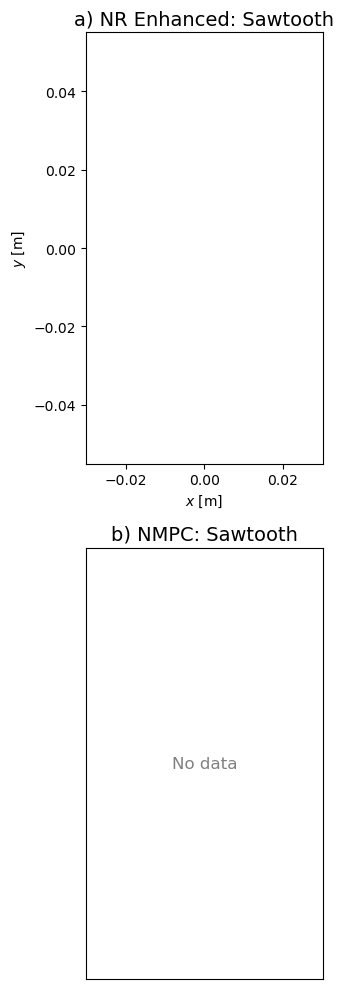

In [6]:
# Get all unique trajectories present in simulation pyjoules data (filtered by included trajectories)
platform_key = 'Simulation PyJoules'
sim_pyj_trajectories = set()
sim_pyj_trajectories.update(organized_data[platform_key][NR_CONTROLLER_CHOICE].keys())
sim_pyj_trajectories.update(organized_data[platform_key]['MPC'].keys())

# Filter to only included trajectories
sim_pyj_trajectories = sim_pyj_trajectories.intersection(INCLUDED_TRAJECTORIES)

# Define preferred order: Circle A, Circle B, Lemniscate A, B, C, then Triangle, then Sawtooth
preferred_order = ['Circle H', 'Circle V', 'Fig8 H', 'Fig8 VS', 'Fig8 VT', 'Triangle', 'Sawtooth']
sim_pyj_traj_ordered = [t for t in preferred_order if t in sim_pyj_trajectories]

# Add any remaining trajectories not in preferred order
for t in sorted(sim_pyj_trajectories):
    if t not in sim_pyj_traj_ordered:
        sim_pyj_traj_ordered.append(t)

print(f"Simulation PyJoules Trajectories ({len(sim_pyj_traj_ordered)}): {sim_pyj_traj_ordered}")

if len(sim_pyj_traj_ordered) > 0:
    fig_sim_pyj = plot_controller_comparison_grid(
        organized_data[platform_key],
        NR_CONTROLLER_CHOICE,
        sim_pyj_traj_ordered,
        'Simulation PyJoules',
        figsize=(3.5 * len(sim_pyj_traj_ordered), 10),
        title_fontsize=subfigure_title_fontsize,
        tick_fontsize=tick_size,
        show_grid=show_gridlines,
        start_trim_s=start_trim_seconds,
        end_trim_s=end_trim_seconds,
        one_cycle_ref=plot_one_cycle_ref,
        cycle_thresh=cycle_detection_threshold,
        lookahead_s=lookahead_time
    )
    
    if fig_sim_pyj is not None:
        save_path = f"{output_path}simulation_pyjoules_comparison.pdf"
        fig_sim_pyj.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"\\nSaved: {save_path}")
        plt.show()
else:
    print("No simulation pyjoules data available for comparison")

## 7. Simulation Non-PyJoules Comparison

Compare NR vs NMPC controllers in simulation using Non-PyJoules logs.

Simulation Non-PyJoules Trajectories (7): ['Circle H', 'Circle V', 'Fig8 H', 'Fig8 VS', 'Fig8 VT', 'Triangle', 'Sawtooth']
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 sa

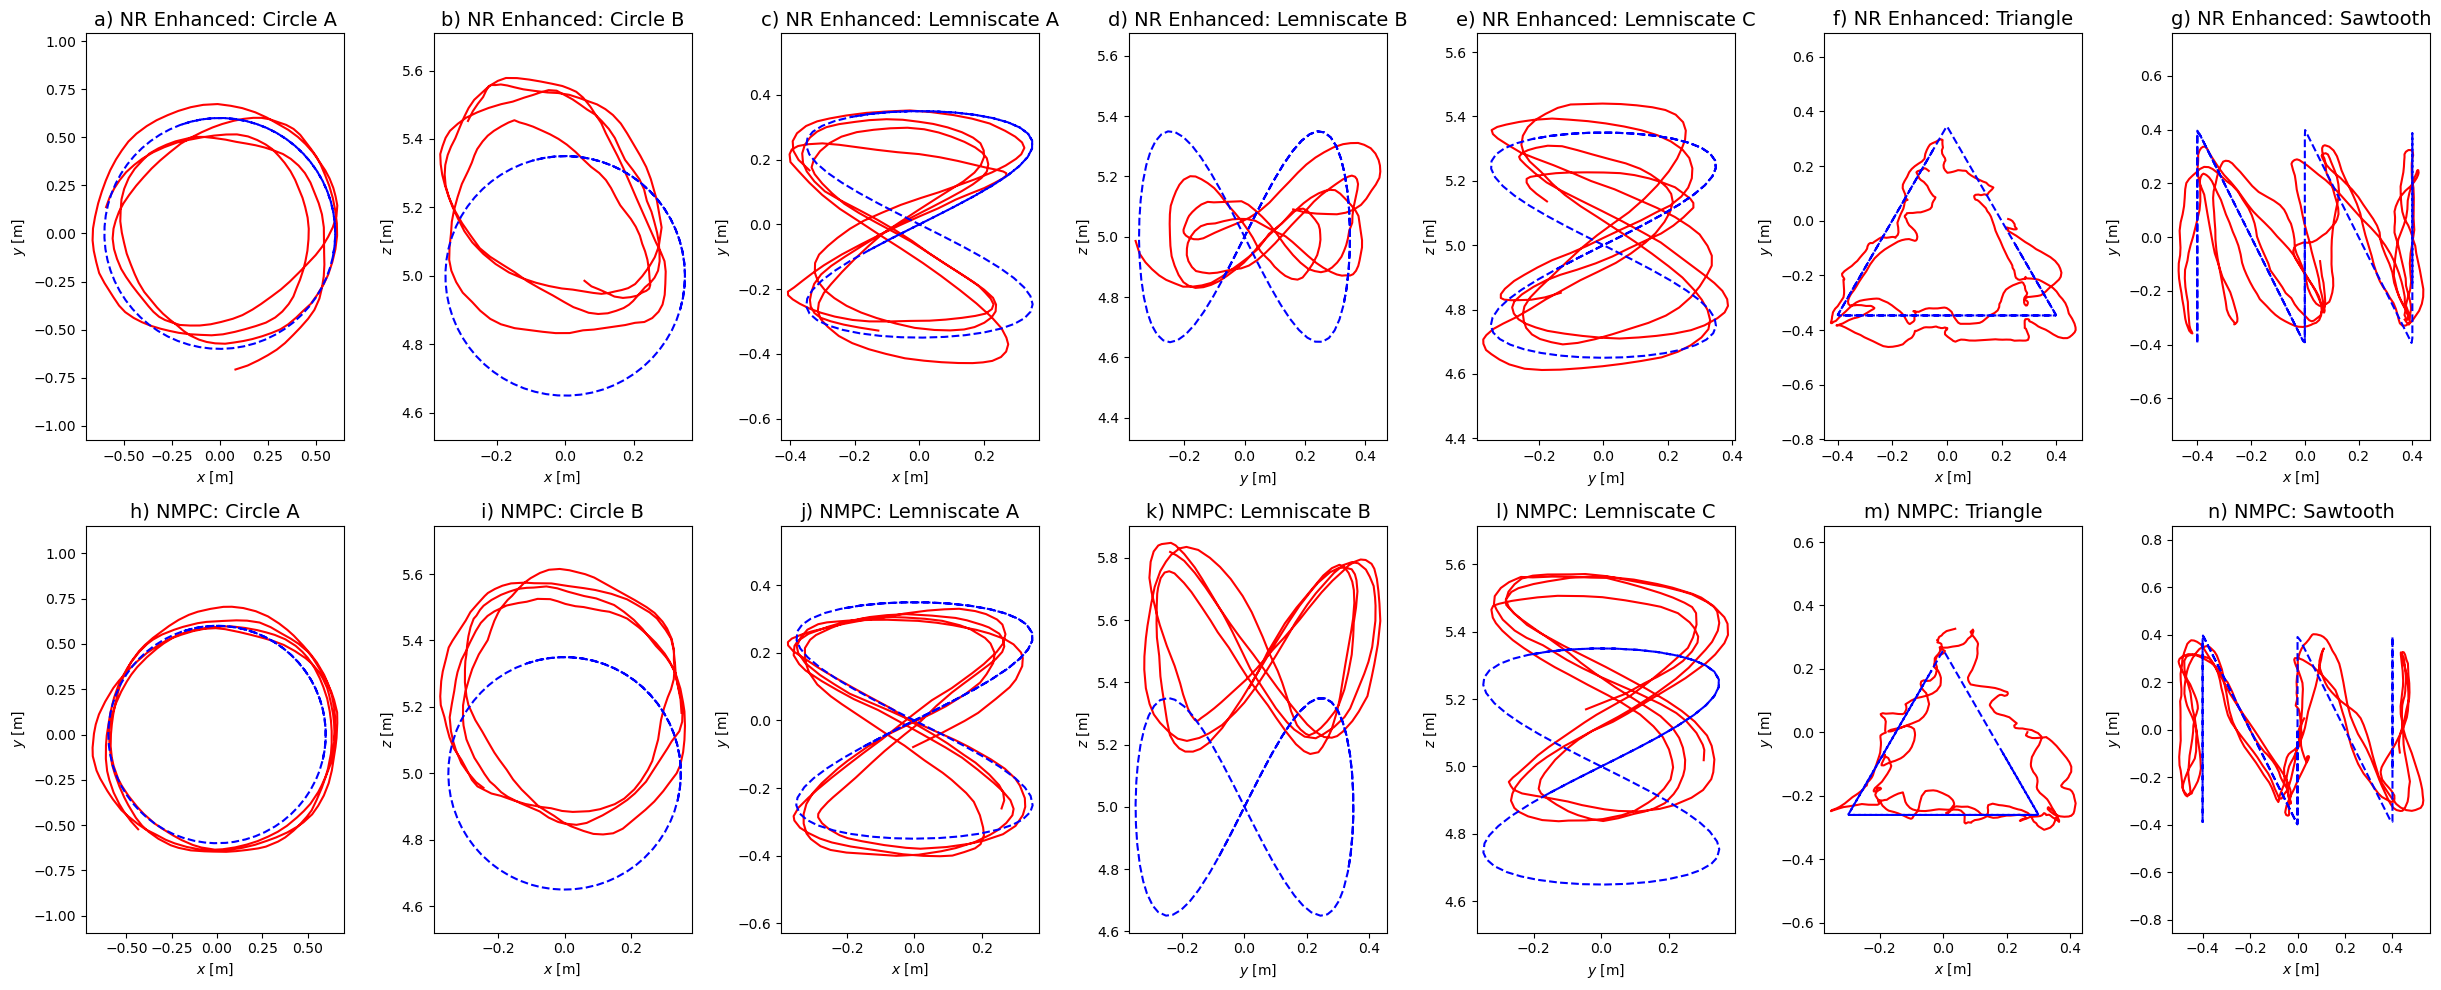

In [7]:
# Get all unique trajectories present in simulation non-pyjoules data (filtered by included trajectories)
platform_key = 'Simulation Non-PyJoules'
sim_non_pyj_trajectories = set()
sim_non_pyj_trajectories.update(organized_data[platform_key][NR_CONTROLLER_CHOICE].keys())
sim_non_pyj_trajectories.update(organized_data[platform_key]['MPC'].keys())

# Filter to only included trajectories
sim_non_pyj_trajectories = sim_non_pyj_trajectories.intersection(INCLUDED_TRAJECTORIES)

# Use same preferred order: Circle A, Circle B, Lemniscate A, B, C, then Triangle, then Sawtooth
sim_non_pyj_traj_ordered = [t for t in preferred_order if t in sim_non_pyj_trajectories]

# Add any remaining trajectories not in preferred order
for t in sorted(sim_non_pyj_trajectories):
    if t not in sim_non_pyj_traj_ordered:
        sim_non_pyj_traj_ordered.append(t)

print(f"Simulation Non-PyJoules Trajectories ({len(sim_non_pyj_traj_ordered)}): {sim_non_pyj_traj_ordered}")

if len(sim_non_pyj_traj_ordered) > 0:
    fig_sim_non_pyj = plot_controller_comparison_grid(
        organized_data[platform_key],
        NR_CONTROLLER_CHOICE,
        sim_non_pyj_traj_ordered,
        'Simulation Non-PyJoules',
        figsize=(3.5 * len(sim_non_pyj_traj_ordered), 10),
        title_fontsize=subfigure_title_fontsize,
        tick_fontsize=tick_size,
        show_grid=show_gridlines,
        start_trim_s=start_trim_seconds,
        end_trim_s=end_trim_seconds,
        one_cycle_ref=plot_one_cycle_ref,
        cycle_thresh=cycle_detection_threshold,
        lookahead_s=lookahead_time
    )
    
    if fig_sim_non_pyj is not None:
        save_path = f"{output_path}simulation_non_pyjoules_comparison.pdf"
        fig_sim_non_pyj.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"\\nSaved: {save_path}")
        plt.show()
else:
    print("No simulation non-pyjoules data available for comparison")

## 8. Hardware PyJoules Comparison

Compare NR vs NMPC controllers on hardware using PyJoules logs.

In [8]:
# Get all unique trajectories present in hardware pyjoules data (filtered by included trajectories)
platform_key = 'Hardware PyJoules'
hw_pyj_trajectories = set()
hw_pyj_trajectories.update(organized_data[platform_key][NR_CONTROLLER_CHOICE].keys())
hw_pyj_trajectories.update(organized_data[platform_key]['MPC'].keys())

# Filter to only included trajectories
hw_pyj_trajectories = hw_pyj_trajectories.intersection(INCLUDED_TRAJECTORIES)

# Use same preferred order: Circle A, Circle B, Lemniscate A, B, C, then Triangle, then Sawtooth
hw_pyj_traj_ordered = [t for t in preferred_order if t in hw_pyj_trajectories]

# Add any remaining trajectories not in preferred order
for t in sorted(hw_pyj_trajectories):
    if t not in hw_pyj_traj_ordered:
        hw_pyj_traj_ordered.append(t)

print(f"Hardware PyJoules Trajectories ({len(hw_pyj_traj_ordered)}): {hw_pyj_traj_ordered}")

if len(hw_pyj_traj_ordered) > 0:
    fig_hw_pyj = plot_controller_comparison_grid(
        organized_data[platform_key],
        NR_CONTROLLER_CHOICE,
        hw_pyj_traj_ordered,
        'Hardware PyJoules',
        figsize=(3.5 * len(hw_pyj_traj_ordered), 10),
        title_fontsize=subfigure_title_fontsize,
        tick_fontsize=tick_size,
        show_grid=show_gridlines,
        start_trim_s=start_trim_seconds,
        end_trim_s=end_trim_seconds,
        one_cycle_ref=plot_one_cycle_ref,
        cycle_thresh=cycle_detection_threshold,
        lookahead_s=lookahead_time
    )
    
    if fig_hw_pyj is not None:
        save_path = f"{output_path}hardware_pyjoules_comparison.pdf"
        fig_hw_pyj.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"\\nSaved: {save_path}")
        plt.show()
else:
    print("No hardware pyjoules data available for comparison")

Hardware PyJoules Trajectories (0): []
No hardware pyjoules data available for comparison


## 9. Hardware Non-PyJoules Comparison

Compare NR vs NMPC controllers on hardware using Non-PyJoules logs.

In [9]:
# Get all unique trajectories present in hardware non-pyjoules data (filtered by included trajectories)
platform_key = 'Hardware Non-PyJoules'
hw_non_pyj_trajectories = set()
hw_non_pyj_trajectories.update(organized_data[platform_key][NR_CONTROLLER_CHOICE].keys())
hw_non_pyj_trajectories.update(organized_data[platform_key]['MPC'].keys())

# Filter to only included trajectories
hw_non_pyj_trajectories = hw_non_pyj_trajectories.intersection(INCLUDED_TRAJECTORIES)

# Use same preferred order: Circle A, Circle B, Lemniscate A, B, C, then Triangle, then Sawtooth
hw_non_pyj_traj_ordered = [t for t in preferred_order if t in hw_non_pyj_trajectories]

# Add any remaining trajectories not in preferred order
for t in sorted(hw_non_pyj_trajectories):
    if t not in hw_non_pyj_traj_ordered:
        hw_non_pyj_traj_ordered.append(t)

print(f"Hardware Non-PyJoules Trajectories ({len(hw_non_pyj_traj_ordered)}): {hw_non_pyj_traj_ordered}")

if len(hw_non_pyj_traj_ordered) > 0:
    fig_hw_non_pyj = plot_controller_comparison_grid(
        organized_data[platform_key],
        NR_CONTROLLER_CHOICE,
        hw_non_pyj_traj_ordered,
        'Hardware Non-PyJoules',
        figsize=(3.5 * len(hw_non_pyj_traj_ordered), 10),
        title_fontsize=subfigure_title_fontsize,
        tick_fontsize=tick_size,
        show_grid=show_gridlines,
        start_trim_s=start_trim_seconds,
        end_trim_s=end_trim_seconds,
        one_cycle_ref=plot_one_cycle_ref,
        cycle_thresh=cycle_detection_threshold,
        lookahead_s=lookahead_time
    )
    
    if fig_hw_non_pyj is not None:
        save_path = f"{output_path}hardware_non_pyjoules_comparison.pdf"
        fig_hw_non_pyj.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"\\nSaved: {save_path}")
        plt.show()
else:
    print("No hardware non-pyjoules data available for comparison")

Hardware Non-PyJoules Trajectories (0): []
No hardware non-pyjoules data available for comparison


## 10. Summary Statistics

Compare RMSE statistics across controllers, platforms, and PyJoules status.

In [10]:
# Collect RMSE statistics
summary_data = []

for platform_key in ['Simulation PyJoules', 'Simulation Non-PyJoules', 
                     'Hardware PyJoules', 'Hardware Non-PyJoules']:
    for controller in [NR_CONTROLLER_CHOICE, 'MPC']:
        for traj_name, data_info in organized_data[platform_key][controller].items():
            # Only include trajectories in our filter
            if traj_name not in INCLUDED_TRAJECTORIES:
                continue
                
            df = data_info['df']
            filename = data_info['filename']
            metadata = data_info['metadata']
            
            # Apply trajectory trimming based on traj_time (same as plotting)
            df_trimmed = df.copy()
            if 'traj_time' in df_trimmed.columns:
                traj_time = df_trimmed['traj_time']
                max_time = traj_time.max()
                
                # Trim start and end
                mask = (traj_time >= start_trim_seconds) & (traj_time <= (max_time - end_trim_seconds))
                df_trimmed = df_trimmed[mask].reset_index(drop=True)
            
            # Apply transformations
            df_temp = df_trimmed.copy()
            df_temp['z'] = -df_temp['z']
            df_temp['z_ref'] = -df_temp['z_ref']
            df_temp = align_reference_to_actual(df_temp, sampling_rate=10.0, lookahead_time_override=lookahead_time)
            
            rmse = calculate_position_rmse(df_temp, flip_z=False, align_lookahead=False)
            pub_name = get_publication_name(traj_name, metadata)
            
            if pub_name is not None:  # Only include if it has a publication name
                summary_data.append({
                    'Platform': platform_key,
                    'Controller': controller,
                    'Trajectory': pub_name,
                    'RMSE (m)': rmse
                })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

if len(summary_df) > 0:
    print("\\n" + "="*80)
    print("RMSE Summary")
    print("="*80)
    print(summary_df.to_string(index=False))
    
    # Save to CSV
    summary_csv_path = f"{output_path}controller_comparison_rmse.csv"
    summary_df.to_csv(summary_csv_path, index=False)
    print(f"\\nSaved: {summary_csv_path}")
    
    # Calculate mean RMSE by controller and platform
    print("\\n" + "="*80)
    print("Mean RMSE by Controller and Platform")
    print("="*80)
    mean_rmse = summary_df.groupby(['Platform', 'Controller'])['RMSE (m)'].mean()
    print(mean_rmse.to_string())
else:
    print("No data available for summary statistics")

Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by

## Summary

This notebook provides controller-to-controller comparison visualizations with separate plots for PyJoules and Non-PyJoules logs.

### Features:
- **Platform and PyJoules Separation**: Four separate plots:
  - Simulation PyJoules logs
  - Simulation Non-PyJoules logs
  - Hardware PyJoules logs
  - Hardware Non-PyJoules logs
- **Matched Trajectories**: Top row (NR) and bottom row (NMPC) show same trajectories
- **Trajectory Order**: Circle A (Horizontal), Circle B (Vertical), Lemniscate A (Horizontal), Lemniscate B (Vertical Short), Lemniscate C (Vertical Tall), Triangle, Sawtooth
- **Trajectory Trimming**: Configurable start and end trimming applied to both plotting and RMSE calculations
- **One Cycle Reference Plotting**: Uses exact cycle times from trajectories.py (Sawtooth shows half cycle, 30s)
- **Configurable Lookahead Time**: Set reference alignment time in config (default 1.2s)
- **Automatic Plane Detection**: Each trajectory uses the optimal 2D projection (handles NaN references in NMPC data)
- **Publication Names**: Trajectories labeled with publication-ready names
- **RMSE Metrics**: Each subplot shows position RMSE for quick comparison

### Output Files:
- `output/simulation_pyjoules_comparison.pdf` - Simulation PyJoules comparison grid
- `output/simulation_non_pyjoules_comparison.pdf` - Simulation Non-PyJoules comparison grid
- `output/hardware_pyjoules_comparison.pdf` - Hardware PyJoules comparison grid
- `output/hardware_non_pyjoules_comparison.pdf` - Hardware Non-PyJoules comparison grid
- `output/controller_comparison_rmse.csv` - RMSE summary table

### Customization:
- Change `NR_CONTROLLER_CHOICE` in the configuration cell to switch between NR Standard and NR Enhanced
- Adjust `start_trim_seconds` and `end_trim_seconds` to remove transients from start/end of trajectories
- Set `lookahead_time` to align reference trajectories (default: 1.2s)
- Set `plot_one_cycle_ref = False` to plot full reference trajectories (default: True)
- Adjust `cycle_detection_threshold` to change sensitivity of cycle detection (default: 0.1 meters)
- Modify `TRAJECTORY_MAP` to adjust trajectory name mappings
- Adjust `preferred_order` in Section 6 to change the column ordering

### Next Steps:
1. Place your log files in `log_files/` with proper metadata columns
2. Ensure PyJoules logs end with `_pyj.csv`
3. Choose your NR controller in the configuration cell
4. Set trimming and lookahead values if needed
5. Run all cells to generate comparison plots
6. Use the generated PDFs in your publication